# 03: Sandbox Model – BRCA1 vs BRCA2 Classifier

This notebook builds a sandbox version of a BRCA variant classifier using filtered VEP annotations
to distinguish BRCA1 vs BRCA2 variants. Includes feature engineering, model training, evaluation,
and SHAP explainability.

⚠️ NOTE: This is a **sandbox** version using manually labeled data. It does not include full pathway
or environmental exposure features.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define your project base path
project_path = "/content/drive/MyDrive/BRCA-pathway-classifier"

# Define commonly used subpaths
data_raw = f"{project_path}/data/raw"
data_processed = f"{project_path}/data/processed"
data_external = f"{project_path}/data/external"
models_path = f"{project_path}/models"
results_path = f"{project_path}/results"
scripts_path = f"{project_path}/scripts"

# Input file: Filtered VEP file
vep_path = f"{data_processed}/brca_vep_output_all_filtered.tsv"

Mounted at /content/drive


In [ ]:
import pandas as pd

# Path to the large filtered VEP file
vep_path = "/content/drive/MyDrive/BRCA-pathway-classifier/data/processed/brca_vep_output_all_filtered.tsv"

# Step 1: Detect header line
with open(vep_path, 'r') as file:
    for i, line in enumerate(file):
        if line.startswith("#Uploaded_variation"):
            header_line = i
            break

# Step 2: Read file starting from header
vep_df = pd.read_csv(vep_path, sep="\t", skiprows=header_line, low_memory=False)

# Step 3: Print columns for inspection
print("✅ Loaded VEP shape:", vep_df.shape)
print("✅ Loaded VEP columns:", list(vep_df.columns))

✅ Loaded VEP shape: (35395, 82)
✅ Loaded VEP columns: ['#Uploaded_variation', 'Location', 'Allele', 'Gene', 'Feature', 'Feature_type', 'Consequence', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'Existing_variation', 'IMPACT', 'DISTANCE', 'STRAND', 'FLAGS', 'VARIANT_CLASS', 'SYMBOL', 'SYMBOL_SOURCE', 'HGNC_ID', 'BIOTYPE', 'CANONICAL', 'MANE', 'MANE_SELECT', 'MANE_PLUS_CLINICAL', 'TSL', 'APPRIS', 'CCDS', 'ENSP', 'SWISSPROT', 'TREMBL', 'UNIPARC', 'UNIPROT_ISOFORM', 'GENE_PHENO', 'SIFT', 'PolyPhen', 'EXON', 'INTRON', 'DOMAINS', 'miRNA', 'HGVSc', 'HGVSp', 'HGVS_OFFSET', 'AF', 'AFR_AF', 'AMR_AF', 'EAS_AF', 'EUR_AF', 'SAS_AF', 'gnomADe_AF', 'gnomADe_AFR_AF', 'gnomADe_AMR_AF', 'gnomADe_ASJ_AF', 'gnomADe_EAS_AF', 'gnomADe_FIN_AF', 'gnomADe_MID_AF', 'gnomADe_NFE_AF', 'gnomADe_REMAINING_AF', 'gnomADe_SAS_AF', 'gnomADg_AF', 'gnomADg_AFR_AF', 'gnomADg_AMI_AF', 'gnomADg_AMR_AF', 'gnomADg_ASJ_AF', 'gnomADg_EAS_AF', 'gnomADg_FIN_AF', 'gnomADg_MID_AF', 'gnomADg_NFE_AF'

In [ ]:
import pandas as pd

# Define path to enriched features
enriched_path = "/content/drive/MyDrive/BRCA-pathway-classifier/data/processed/brca_features_enriched.csv"

# Load features
df = pd.read_csv(enriched_path, index_col=0)

# Confirm shape
print("✅ Loaded enriched features:", df.shape)

# Add label column: BRCA1 = 0, BRCA2 = 1
if "SYMBOL_BRCA2" in df.columns:
    df["label"] = df["SYMBOL_BRCA2"]
elif "SYMBOL_BRCA1" in df.columns:
    df["label"] = 0  # fallback for testing if BRCA2 is missing
else:
    raise ValueError("❌ Neither SYMBOL_BRCA1 nor SYMBOL_BRCA2 found in columns!")

print("✅ Label column added.")

✅ Loaded enriched features: (35395, 2215)
✅ Label column added.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Drop label column to get features
X = df.drop(columns=["label"])
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("✅ Classification Report:\n", classification_report(y_test, y_pred))

✅ Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      4441
        True       1.00      1.00      1.00      6178

    accuracy                           1.00     10619
   macro avg       1.00      1.00      1.00     10619
weighted avg       1.00      1.00      1.00     10619



✅ X_numeric shape: (35395, 2215)
✅ dtypes:
 float64    2215
Name: count, dtype: int64


100%|===================| 70741/70790 [07:15<00:00]       

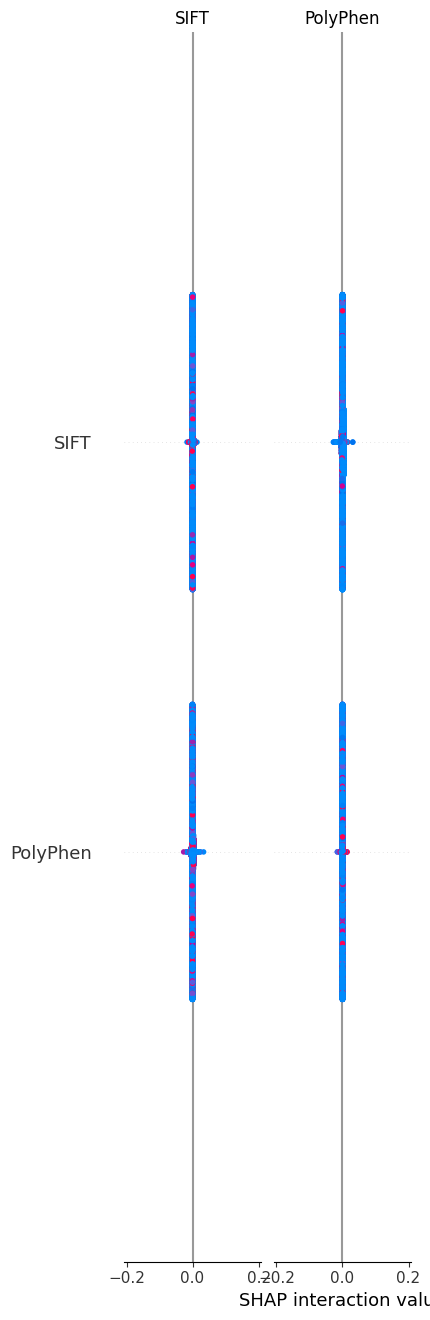

In [ ]:
import shap

# Convert all features to numeric, then cast to float
X_numeric = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

# Confirm shape and types
print("✅ X_numeric shape:", X_numeric.shape)
print("✅ dtypes:\n", X_numeric.dtypes.value_counts())

# Create SHAP explainer and compute SHAP values
explainer = shap.Explainer(model, X_numeric)
shap_values = explainer(X_numeric)

# Plot top 15 important features
shap.summary_plot(shap_values, X_numeric, max_display=15)


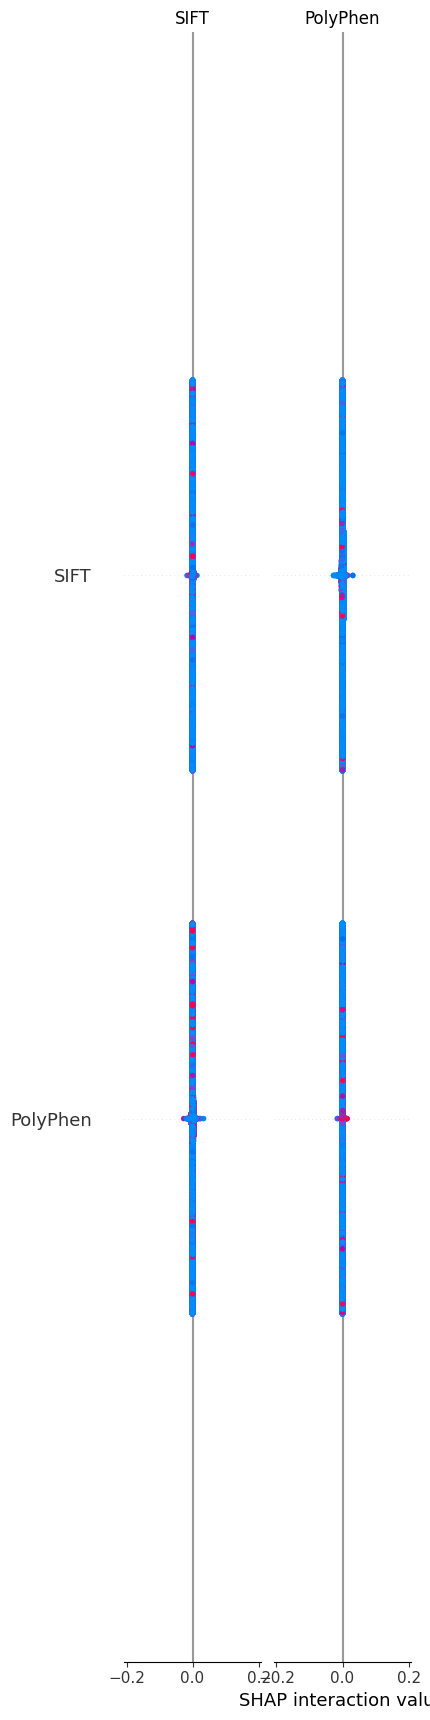

In [ ]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_numeric, max_display=20)

In [ ]:
import pandas as pd

# Select only SHAP values for class 1 (BRCA2)
shap_df = pd.DataFrame(shap_values.values[:, :, 1], columns=X_numeric.columns)

# Save to CSV
shap_df.to_csv(f"{results_path}/shap_values.csv", index=False)
print("✅ SHAP values saved:", shap_df.shape)

✅ SHAP values saved: (35395, 2215)


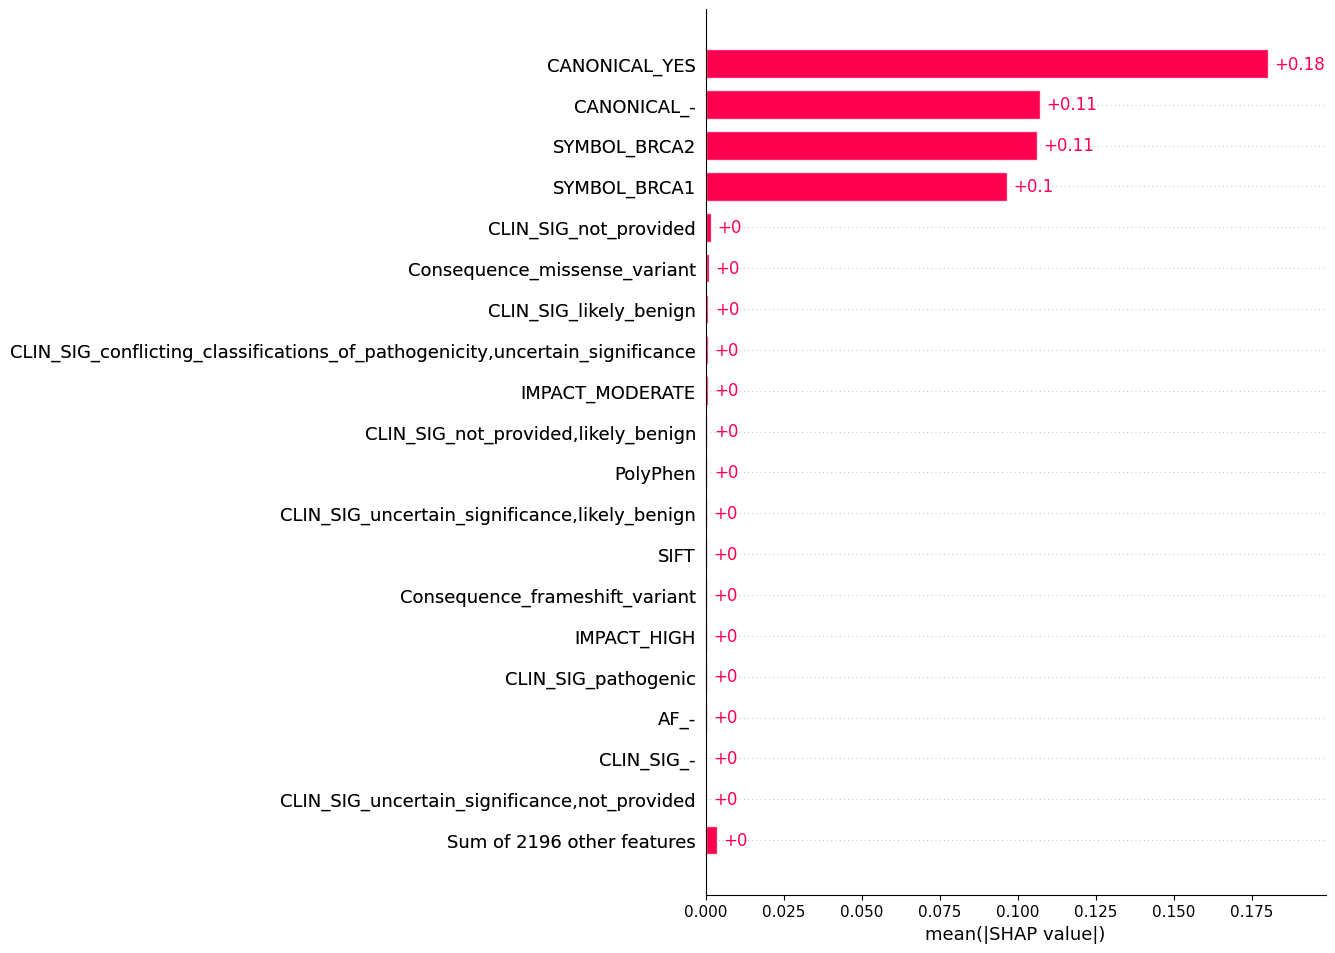

In [ ]:
# Select SHAP values for class 1 (BRCA2)
shap_values_class1 = shap.Explanation(
    values=shap_values.values[:, :, 1],
    base_values=shap_values.base_values[:, 1],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

# Plot bar chart
shap.plots.bar(shap_values_class1, max_display=20)

/tmp/ipython-input-2044907052.py:30: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


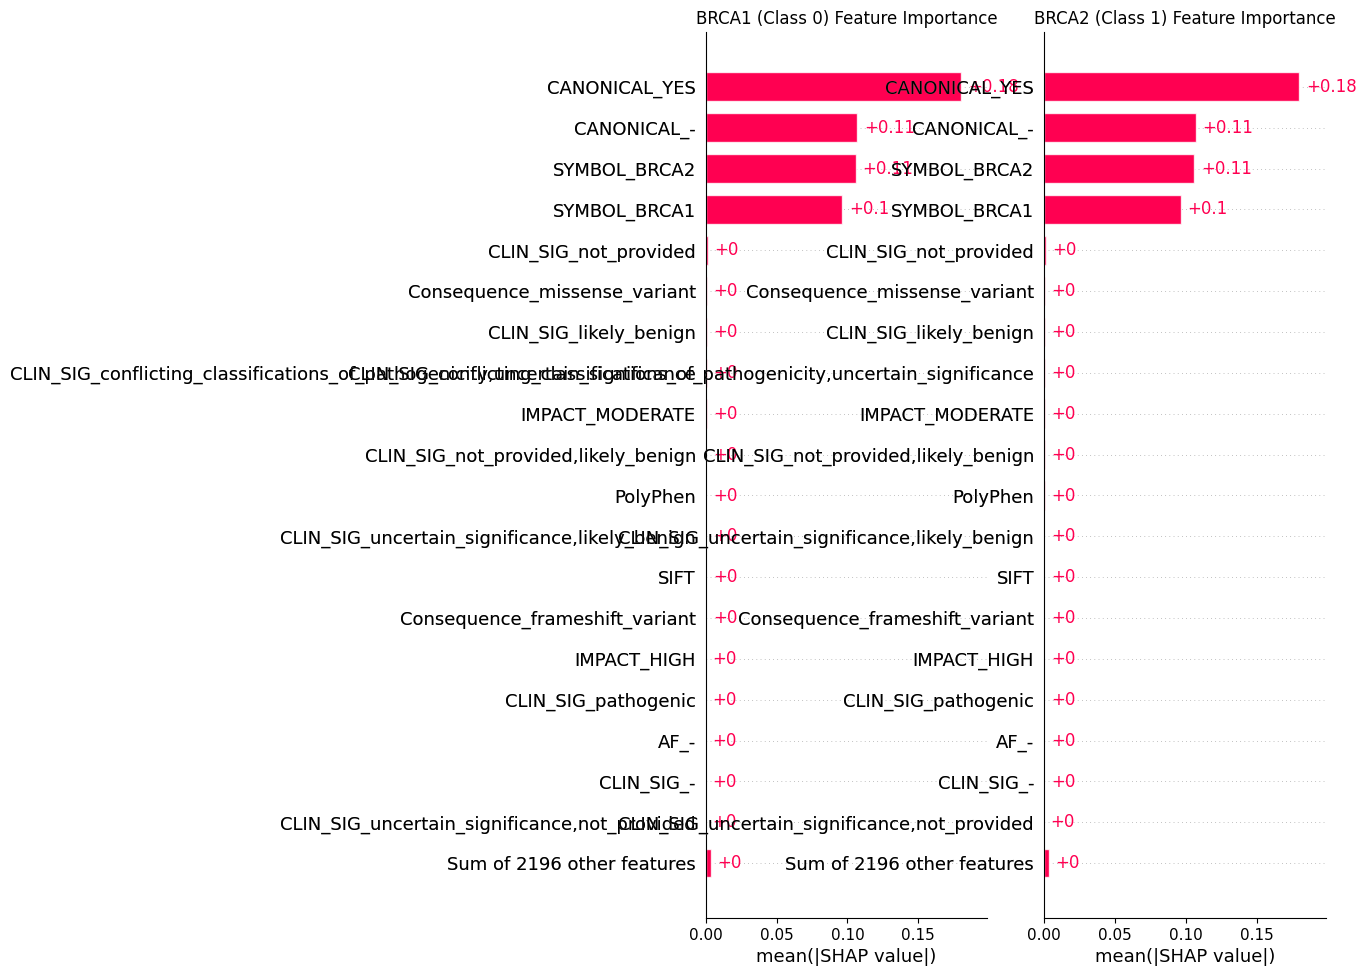

In [ ]:
# ✅ Select class 0 (BRCA1) SHAP values
shap_values_brca1 = shap.Explanation(
    values=shap_values.values[:, :, 0],
    base_values=shap_values.base_values[:, 0],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

# ✅ Select class 1 (BRCA2) SHAP values
shap_values_brca2 = shap.Explanation(
    values=shap_values.values[:, :, 1],
    base_values=shap_values.base_values[:, 1],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

# ✅ Plot side-by-side bar plots
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
shap.plots.bar(shap_values_brca1, max_display=20, show=False)
plt.title("BRCA1 (Class 0) Feature Importance")

plt.subplot(1, 2, 2)
shap.plots.bar(shap_values_brca2, max_display=20, show=False)
plt.title("BRCA2 (Class 1) Feature Importance")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Function to compute top features
def top_shap_features(shap_vals, feature_names, top_n=20):
    mean_abs = np.abs(shap_vals).mean(axis=0)
    top_idx = np.argsort(mean_abs)[::-1][:top_n]
    return pd.DataFrame({
        "Feature": [feature_names[i] for i in top_idx],
        "Mean_Abs_SHAP": mean_abs[top_idx]
    })

# Get top 20 for each class
top_brca1 = top_shap_features(shap_values.values[:, :, 0], shap_values.feature_names)
top_brca2 = top_shap_features(shap_values.values[:, :, 1], shap_values.feature_names)

# Save to CSV
top_brca1.to_csv(f"{results_path}/top_shap_brca1.csv", index=False)
top_brca2.to_csv(f"{results_path}/top_shap_brca2.csv", index=False)

print("✅ Exported top SHAP features to:")
print(f"  → {results_path}/top_shap_brca1.csv")
print(f"  → {results_path}/top_shap_brca2.csv")

✅ Exported top SHAP features to:
  → /content/drive/MyDrive/BRCA-pathway-classifier/results/top_shap_brca1.csv
  → /content/drive/MyDrive/BRCA-pathway-classifier/results/top_shap_brca2.csv


In [ ]:
import pandas as pd
import numpy as np

# Mean absolute SHAP values per class (global importance)
shap_brca1 = np.abs(shap_values.values[:, :, 0]).mean(axis=0)
shap_brca2 = np.abs(shap_values.values[:, :, 1]).mean(axis=0)

# Combine into one DataFrame
shap_summary_df = pd.DataFrame({
    "Feature": X_numeric.columns,
    "BRCA1_SHAP": shap_brca1,
    "BRCA2_SHAP": shap_brca2
})

# Sort by BRCA2 (you can change to BRCA1 if preferred)
shap_summary_df = shap_summary_df.sort_values("BRCA2_SHAP", ascending=False)

# Save to CSV
shap_summary_path = f"{results_path}/shap_values_brca1_vs_brca2.csv"
shap_summary_df.to_csv(shap_summary_path, index=False)

print("✅ SHAP comparison saved to:", shap_summary_path)
shap_summary_df.head(10)

✅ SHAP comparison saved to: /content/drive/MyDrive/BRCA-pathway-classifier/results/shap_values_brca1_vs_brca2.csv


,Feature,BRCA1_SHAP,BRCA2_SHAP
76,CANONICAL_YES,0.180241,0.180241
75,CANONICAL_-,0.107071,0.107071
73,SYMBOL_BRCA2,0.106133,0.106133
72,SYMBOL_BRCA1,0.096510,0.096510
2081,CLIN_SIG_not_provided,0.001581,0.001581
16,Consequence_missense_variant,0.000933,0.000933
1999,CLIN_SIG_likely_benign,0.000915,0.000915
1986,CLIN_SIG_conflicting_classifications_of_pathog...,0.000683,0.000683
70,IMPACT_MODERATE,0.000650,0.000650
2091,"CLIN_SIG_not_provided,likely_benign",0.000573,0.000573


🔵 BRCA1 (class 0) feature impact


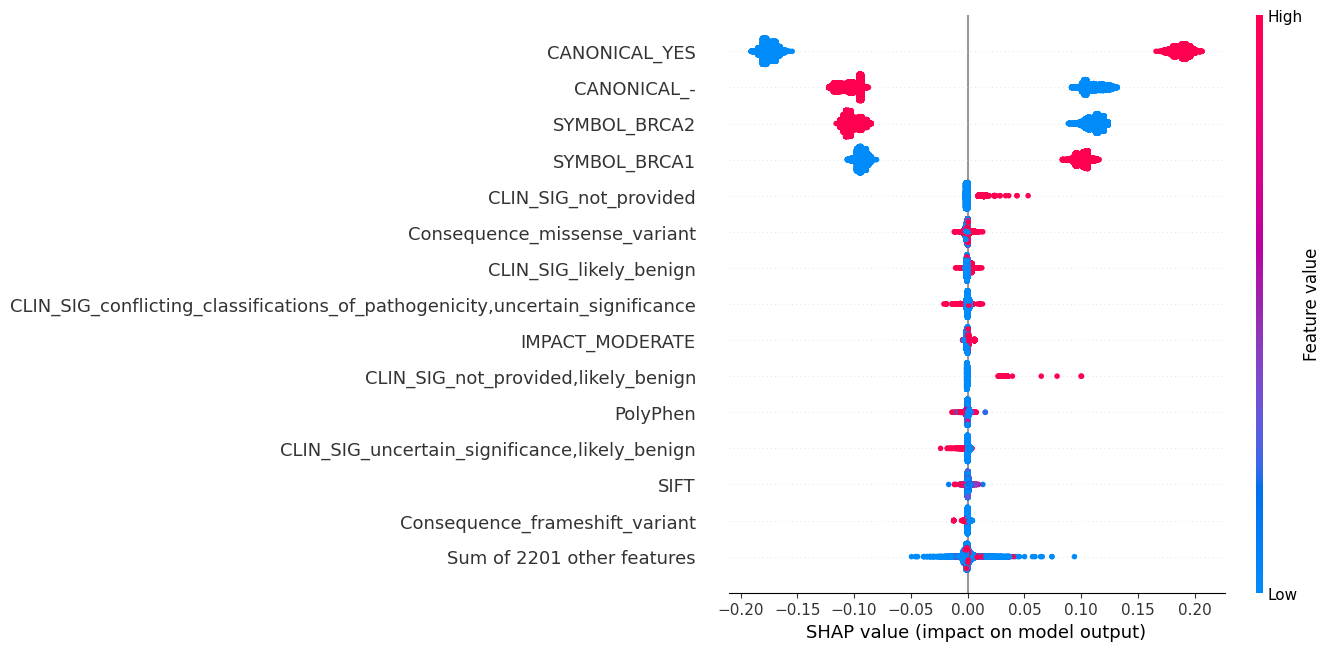

🟣 BRCA2 (class 1) feature impact


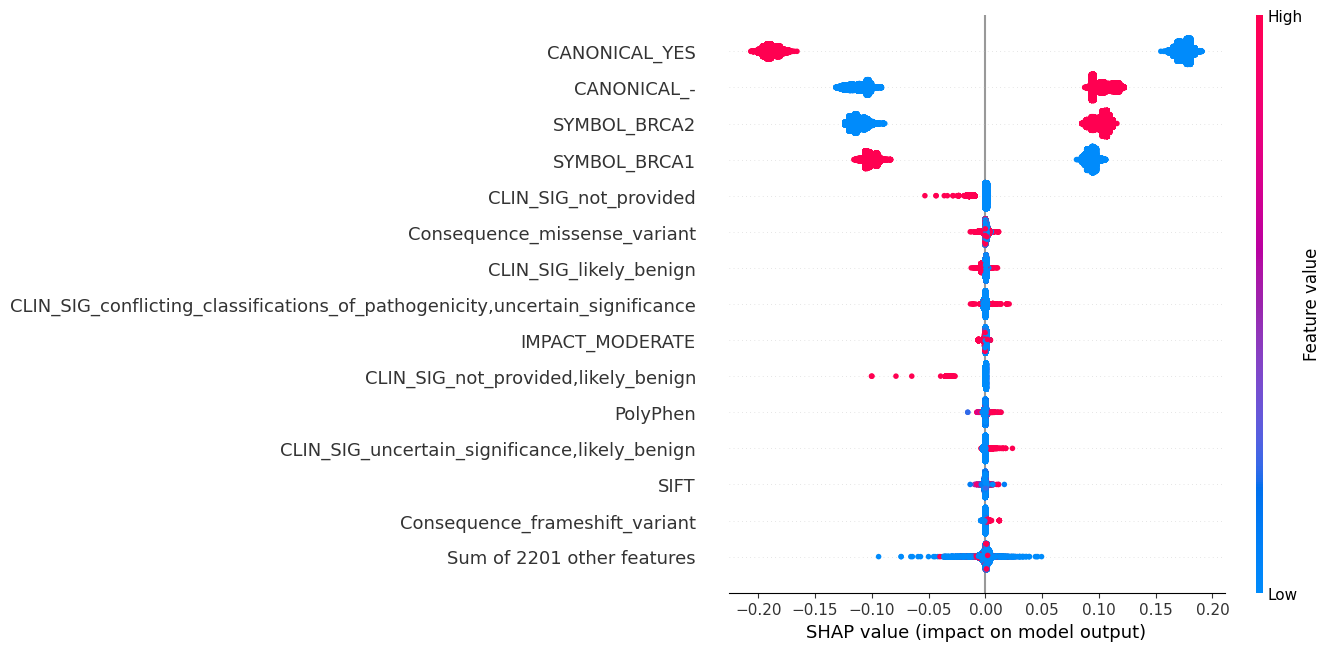

In [ ]:
import shap
import matplotlib.pyplot as plt

# Plot for BRCA1 (class 0)
print("🔵 BRCA1 (class 0) feature impact")
shap.plots.beeswarm(shap_values[:, :, 0], max_display=15)

# Plot for BRCA2 (class 1)
print("🟣 BRCA2 (class 1) feature impact")
shap.plots.beeswarm(shap_values[:, :, 1], max_display=15)

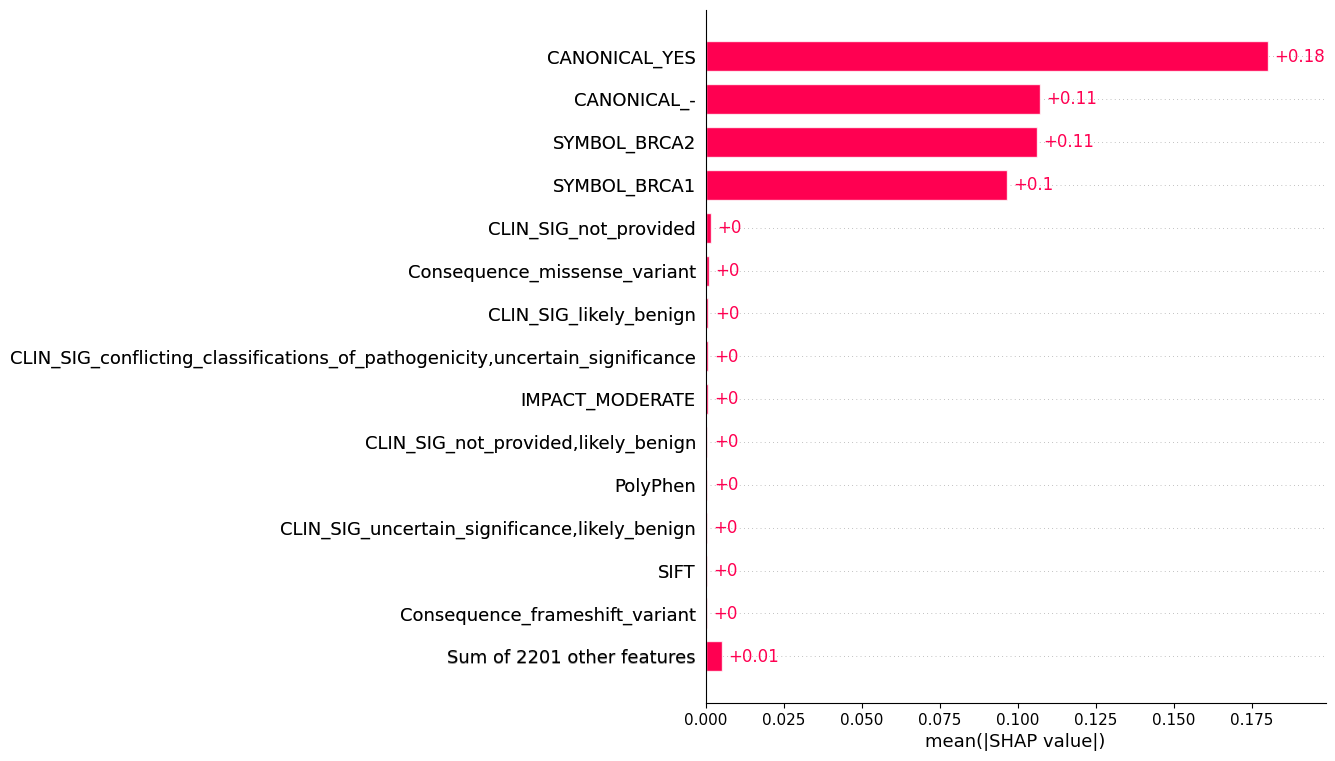

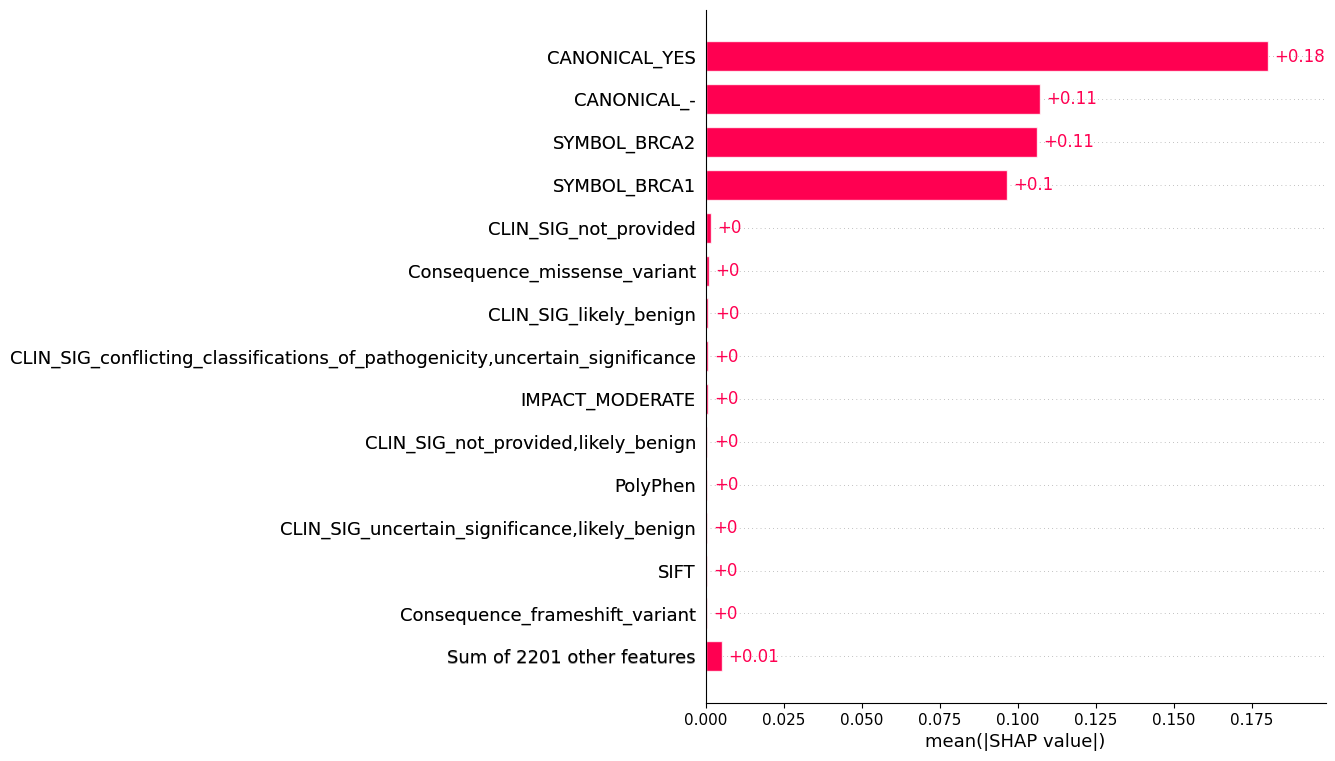

In [ ]:
# Bar plots (average absolute SHAP values per feature)
shap.plots.bar(shap_values[:, :, 0], max_display=15, show=True)  # BRCA1
shap.plots.bar(shap_values[:, :, 1], max_display=15, show=True)  # BRCA2

In [ ]:
import matplotlib.pyplot as plt

# Save BRCA1 SHAP plot
plt.figure()
shap.plots.beeswarm(shap_values[:, :, 0], max_display=15, show=False)
plt.title("SHAP Summary — BRCA1 (Class 0)")
plt.savefig(f"{results_path}/shap_beeswarm_brca1.png", dpi=300, bbox_inches='tight')
plt.close()

# Save BRCA2 SHAP plot
plt.figure()
shap.plots.beeswarm(shap_values[:, :, 1], max_display=15, show=False)
plt.title("SHAP Summary — BRCA2 (Class 1)")
plt.savefig(f"{results_path}/shap_beeswarm_brca2.png", dpi=300, bbox_inches='tight')
plt.close()

In [22]:
import os

# Define your Google Drive project path
drive_path = "/content/drive/MyDrive/BRCA-pathway-classifier"

# Walk through all subfolders and print files
for root, dirs, files in os.walk(drive_path):
    for file in files:
        full_path = os.path.join(root, file)
        print(full_path)

/content/drive/MyDrive/BRCA-pathway-classifier/README.md
/content/drive/MyDrive/BRCA-pathway-classifier/Top 15 Features by SHAP Importance (BRCA1 vs BRCA2).png
/content/drive/MyDrive/BRCA-pathway-classifier/SHAP_Interpretation_BRCA1_vs_BRCA2.pptx
/content/drive/MyDrive/BRCA-pathway-classifier/notebooks/Code for Mounting Google Drive.ipynb
/content/drive/MyDrive/BRCA-pathway-classifier/notebooks/phase3_sandbox_model/03_sandbox_model_brca1_vs_brca2_clean.ipynb
/content/drive/MyDrive/BRCA-pathway-classifier/notebooks/phase3_sandbox_model/brca_sandbox_model_v1.ipynb
/content/drive/MyDrive/BRCA-pathway-classifier/notebooks/phase2_dataset_build/01_feature_engineering.ipynb
/content/drive/MyDrive/BRCA-pathway-classifier/notebooks/phase2_dataset_build/final_01_feature_engineering.ipynb
/content/drive/MyDrive/BRCA-pathway-classifier/notebooks/phase2_dataset_build/brca_phase3_dataset_build.ipynb
/content/drive/MyDrive/BRCA-pathway-classifier/notebooks/phase1_vep_annotation/brca_vep_annotation_pi